<a href="https://colab.research.google.com/github/AtSourav/CatsnDogs_VAE/blob/main/MNIST_beta1_noreg_l10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Defining the model**

In [40]:
import numpy as np
import tensorflow as tf
from tensorflow import keras       # cannot use the name tf to import modules, can only use it to call functions or modules
from keras import losses
from keras import layers
from keras import utils
from keras import backend as K
from keras.datasets import mnist

import os
import matplotlib.pyplot as plt


In [18]:
input_size = (14,14,1)
latent_dim = 10
batch_size = 64


In [19]:
(img_train, tg_train), (img_valid, tg_valid) = mnist.load_data()

img_ht = img_train.shape[1]         #the shape of the data is (count, ht, wd)
img_wd = img_train.shape[2]
count_train = img_train.shape[0]
count_valid = img_valid.shape[0]

img_train = img_train.reshape(count_train,img_ht,img_wd, 1)     # we are adding the channel axis manually
img_valid = img_valid.reshape(count_valid,img_ht,img_wd, 1)

print(img_train.shape)
print(img_valid.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [20]:
img_train = layers.Resizing(14, 14, interpolation="bilinear")(img_train)
img_valid = layers.Resizing(14, 14, interpolation="bilinear")(img_valid)

img_train = img_train/255.
img_valid = img_valid/255.

print(img_train.shape)
print(img_valid.shape)


(60000, 14, 14, 1)
(10000, 14, 14, 1)


In [32]:
# l2_reg = keras.regularizers.L2(l2=0.001)

In [21]:
encoder_input = keras.Input(shape=input_size)

x = layers.Conv2D(10, 2, padding="valid")(encoder_input)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="same")(x)    # with strides=None this defaults to pool_size
#x = layers.SpatialDropout2D(0.01)(x)
#x = layers.BatchNormalization(axis=-1)(x) # the default data_format in the conv2d is "channels last", we want to normalize across the channels, hence we set axis=-1
x = layers.ReLU()(x)

x = layers.Conv2D(30, 2, padding="valid")(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding="valid")(x)
#x = layers.SpatialDropout2D(0.01)(x)
#x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(50, 2, padding="valid")(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(1,1), padding="valid")(x)
#x = layers.SpatialDropout2D(0.001)(x)
#x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

x = layers.Flatten()(x)

#x = layers.Dense(8*latent_dim)(x)
x = layers.Dense(2*latent_dim)(x)
#x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

def sampling(arg):
  z_m, z_log_v = arg
  batch = tf.shape(z_m)[0]
  dim = tf.shape(z_m)[1]
  eps = tf.random.normal(shape=(batch,dim))
  return z_m + tf.exp(0.5*z_log_v)*eps

z = layers.Lambda(sampling)([z_mean,z_log_var])   # we feed the sampling function in to a Lambda layer to build form a layer for the architecture as keras needs

encoder = keras.Model(encoder_input, [z_mean, z_log_var, z], name='encoder')           # the second argument specifies that the encoder outputs [z_mean, z_log_var, z] for each input.
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 14, 14, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 13, 13, 10)           50        ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 7, 7, 10)             0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 re_lu (ReLU)                (None, 7, 7, 10)             0         ['max_pooling2d[0][0]'] 

In [22]:
latent_input = keras.Input(shape=(latent_dim,))

x = layers.Dense(2*latent_dim)(latent_input)
#x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x
                  )
x = layers.Dense(30)(x)
#x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

x = layers.Dense(50)(x)
# = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

x = layers.Reshape((1,1,50))(x)

x = layers.Conv2DTranspose(30, 2, strides=2, padding='same')(x)
#x = layers.SpatialDropout2D(0.001)(x)
#x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(20, 2, strides=2, padding='same')(x)
#x = layers.SpatialDropout2D(0.01)(x)
#x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(10, 2, strides=2, padding='same')(x)
#x = layers.SpatialDropout2D(0.01)(x)
#x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(1,1), padding="valid")(x)
x = layers.ReLU()(x)

decoder_output = layers.Conv2DTranspose(1, 2, activation='sigmoid', strides=2, padding='same')(x)

decoder = keras.Model(latent_input, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_1 (Dense)             (None, 20)                220       
                                                                 
 re_lu_4 (ReLU)              (None, 20)                0         
                                                                 
 dense_2 (Dense)             (None, 30)                630       
                                                                 
 re_lu_5 (ReLU)              (None, 30)                0         
                                                                 
 dense_3 (Dense)             (None, 50)                1550      
                                                                 
 re_lu_6 (ReLU)              (None, 50)                0   

Now let's instantiate the VAE by combininb the encoder and the decoder layers.

In [23]:
decoder_out = decoder(encoder(encoder_input)[2])          # we feed in z from the encoder output
VAE = keras.Model(encoder_input, decoder_out, name='VAE')

VAE.summary()

Model: "VAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14, 14, 1)]       0         
                                                                 
 encoder (Functional)        [(None, 10),              8770      
                              (None, 10),                        
                              (None, 10)]                        
                                                                 
 decoder (Functional)        (None, 14, 14, 1)         11701     
                                                                 
Total params: 20471 (79.96 KB)
Trainable params: 20471 (79.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


We shall define the loss function now, it's made of the reconstruction loss that tries to ensure repoducibility of the data, and the KL divergence loss that tries to ensure that the learned (approximate) posterior is close to the true posterior.

We shall keep a relative weight beta between the two terms in the total loss as a hyperparameter. We may want to investigate the effects of varying this hyperparameter eventually.

In [24]:
beta=1 #we shall vary this later

def vae_loss(true,pred):
  reconstruction_loss = tf.reduce_mean(tf.reduce_sum(losses.binary_crossentropy(true,pred), axis=(1,2) ))

  z_m = encoder(true)[0]
  z_l_v = encoder(true)[1]

  kl_div = tf.reduce_mean(tf.reduce_sum(-0.5*(1 + z_l_v - tf.square(z_m) - tf.exp(z_l_v)),1), -1)

  return reconstruction_loss + beta*kl_div

In [25]:
#lr_decay = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.0001, decay_steps=10000000, decay_rate=0.99, staircase=True)
optim = keras.optimizers.Adam(learning_rate = 0.001)
VAE.compile(optimizer=optim,loss=vae_loss)

# **Running up to 15 epochs**

In [26]:
history = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=120, steps_per_epoch=None)


Epoch 1/120
938/938 [==============================] - 27s 24ms/step - loss: 56.6199 - val_loss: 50.9419
Epoch 2/120
938/938 [==============================] - 21s 23ms/step - loss: 50.1094 - val_loss: 49.3525
Epoch 3/120
938/938 [==============================] - 23s 24ms/step - loss: 49.2503 - val_loss: 48.9771
Epoch 4/120
938/938 [==============================] - 23s 24ms/step - loss: 48.9040 - val_loss: 48.6495
Epoch 5/120
938/938 [==============================] - 21s 23ms/step - loss: 48.5814 - val_loss: 48.2568
Epoch 6/120
938/938 [==============================] - 23s 24ms/step - loss: 48.2923 - val_loss: 47.9917
Epoch 7/120
938/938 [==============================] - 23s 24ms/step - loss: 47.5746 - val_loss: 46.9165
Epoch 8/120
938/938 [==============================] - 23s 24ms/step - loss: 46.7105 - val_loss: 46.3913
Epoch 9/120
938/938 [==============================] - 21s 23ms/step - loss: 46.3739 - val_loss: 46.2578
Epoch 10/120
938/938 [==============================] -

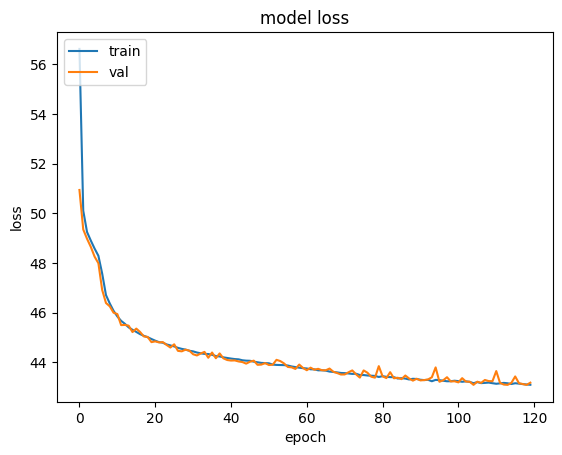

In [27]:
plt.plot(history.history['loss'])         # history.history is a dict with performance metrics as keys
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

The model is not overfitting even after 120 epochs, which is a little strange considering there's no regularisation in the encoder/decoder, probably has to do with beta being 1 as the kl term helps in generalisation. Also, the MNIST dataset is probably easy in the sense that the validation set is pretty similar to the training set.

In [28]:
def plot_reconstruction(set, name,seed_val, epochs):     #name should be either 'training' or 'validation'
  np.random.seed(seed_val)

  tg_indices = np.random.randint(0,set.shape[0],size = 100)
  img_sample = tf.convert_to_tensor(np.array(set)[tg_indices])
  _,_,z_sample = encoder(img_sample)
  img_recon = decoder(z_sample)

  digits_recon = plt.figure(figsize=(21,10))    # we leave one column of difference between the 10x10 grid of training images and 10x10 of validation images
                                        # it's weird that the order of axes in figsize is the opposite to that in add_subplot
  digits_recon.suptitle('Reconstructed images (right) from the ' + name + '-set after ' + str(epochs) + ' epochs: no regularisation in the encoder, decoder, beta=1, latent_dim = 10', fontweight= 'bold', y=0.93)

  digits_recon.tight_layout()

  for i in range(210):
    digits_recon.add_subplot(10,21,i+1)
    j = int(np.floor(i/21))
    if (i%21) <10:
      img = set[tg_indices[j*10 + (i%21)]]
      plt.imshow(img, cmap='gray')
      plt.axis('off')
    elif (i%21)==10:
      img = np.ones((14,14,1))
      plt.imshow(img, cmap='gray')
      plt.axis('off')
    else:
      img = img_recon[j*10 + (i%21) - 11]
      plt.imshow(img, cmap='gray')
      plt.axis('off')

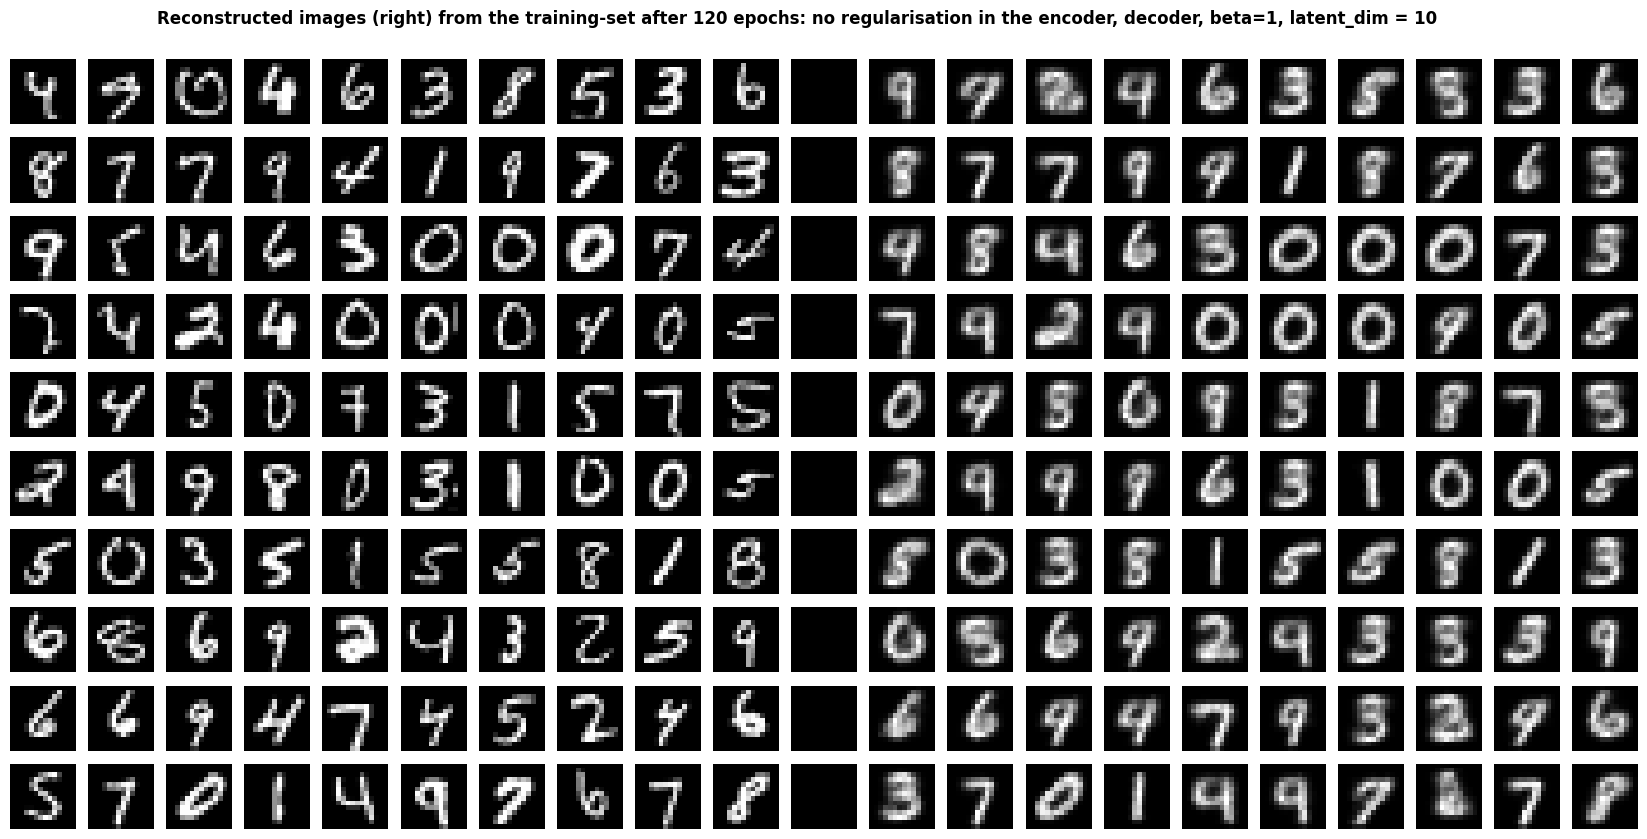

In [29]:
plot_reconstruction(img_train, 'training', 123, 120)

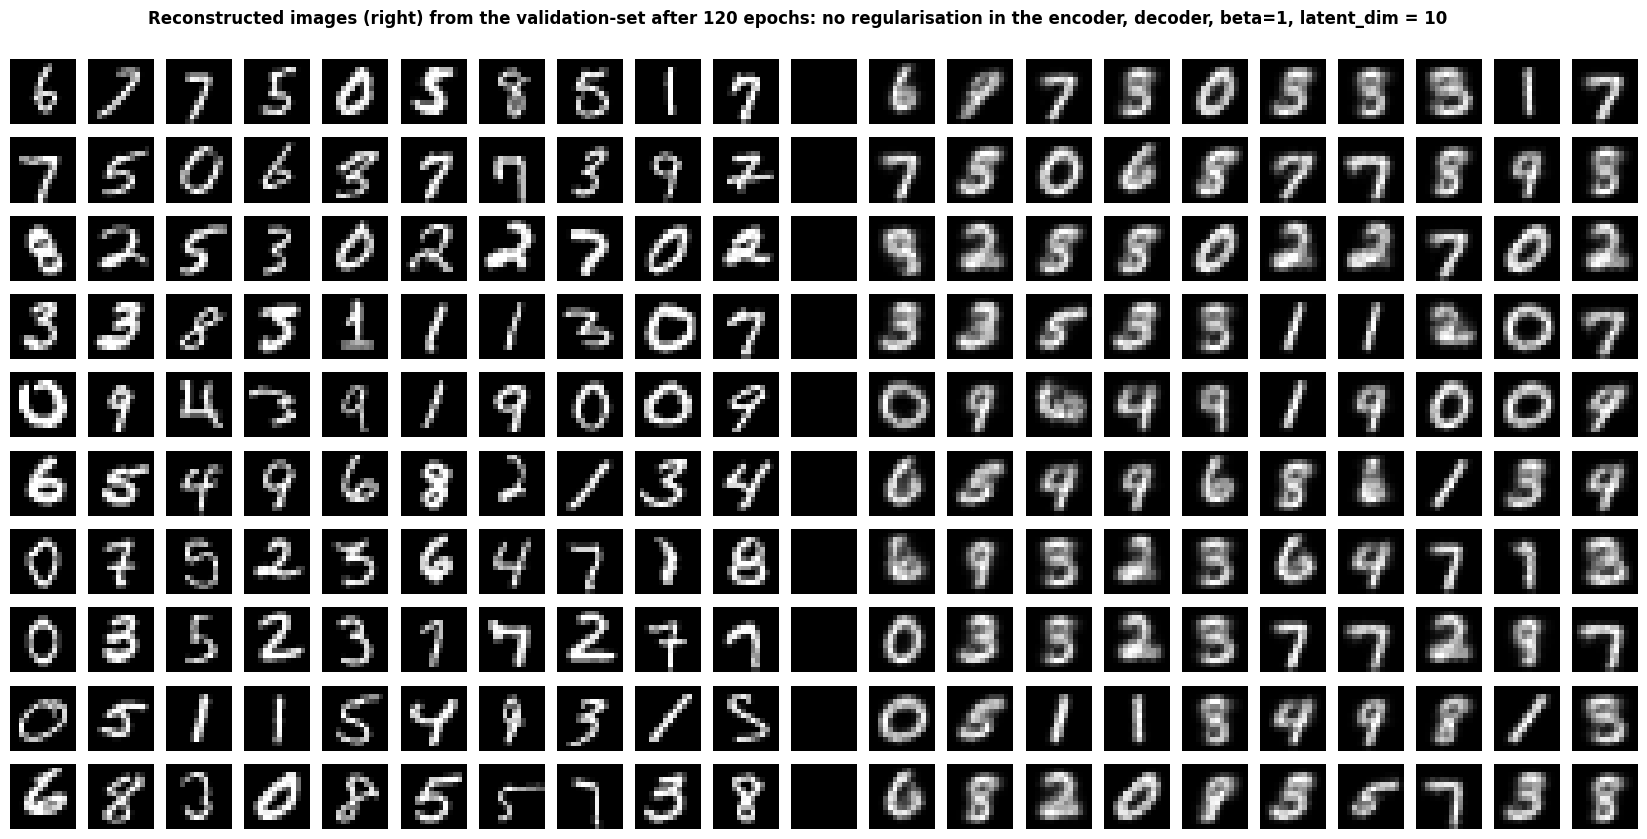

In [32]:
plot_reconstruction(img_valid, 'validation', 121, 120)

In [57]:
def plot_generated(scale,edge, epochs):   # edge is the length of the square grid we want to create

  z_rand = tf.convert_to_tensor(-scale + 2*scale*np.random.random((edge**2,latent_dim)))

  img_rand = decoder(z_rand)

  digits_rand = plt.figure(figsize=(edge,edge))
  digits_rand.suptitle('Some randomly generated images (after '+ str(epochs) + ' epochs of training): no regularisation in the encoder, decoder, beta=1, latent_dim = 10', fontweight= 'bold', y=0.93)


  for i in range(edge**2):
    digits_rand.add_subplot(edge,edge,i+1)
    img = img_rand[i]
    plt.imshow(img, cmap='gray')
    plt.axis('off')

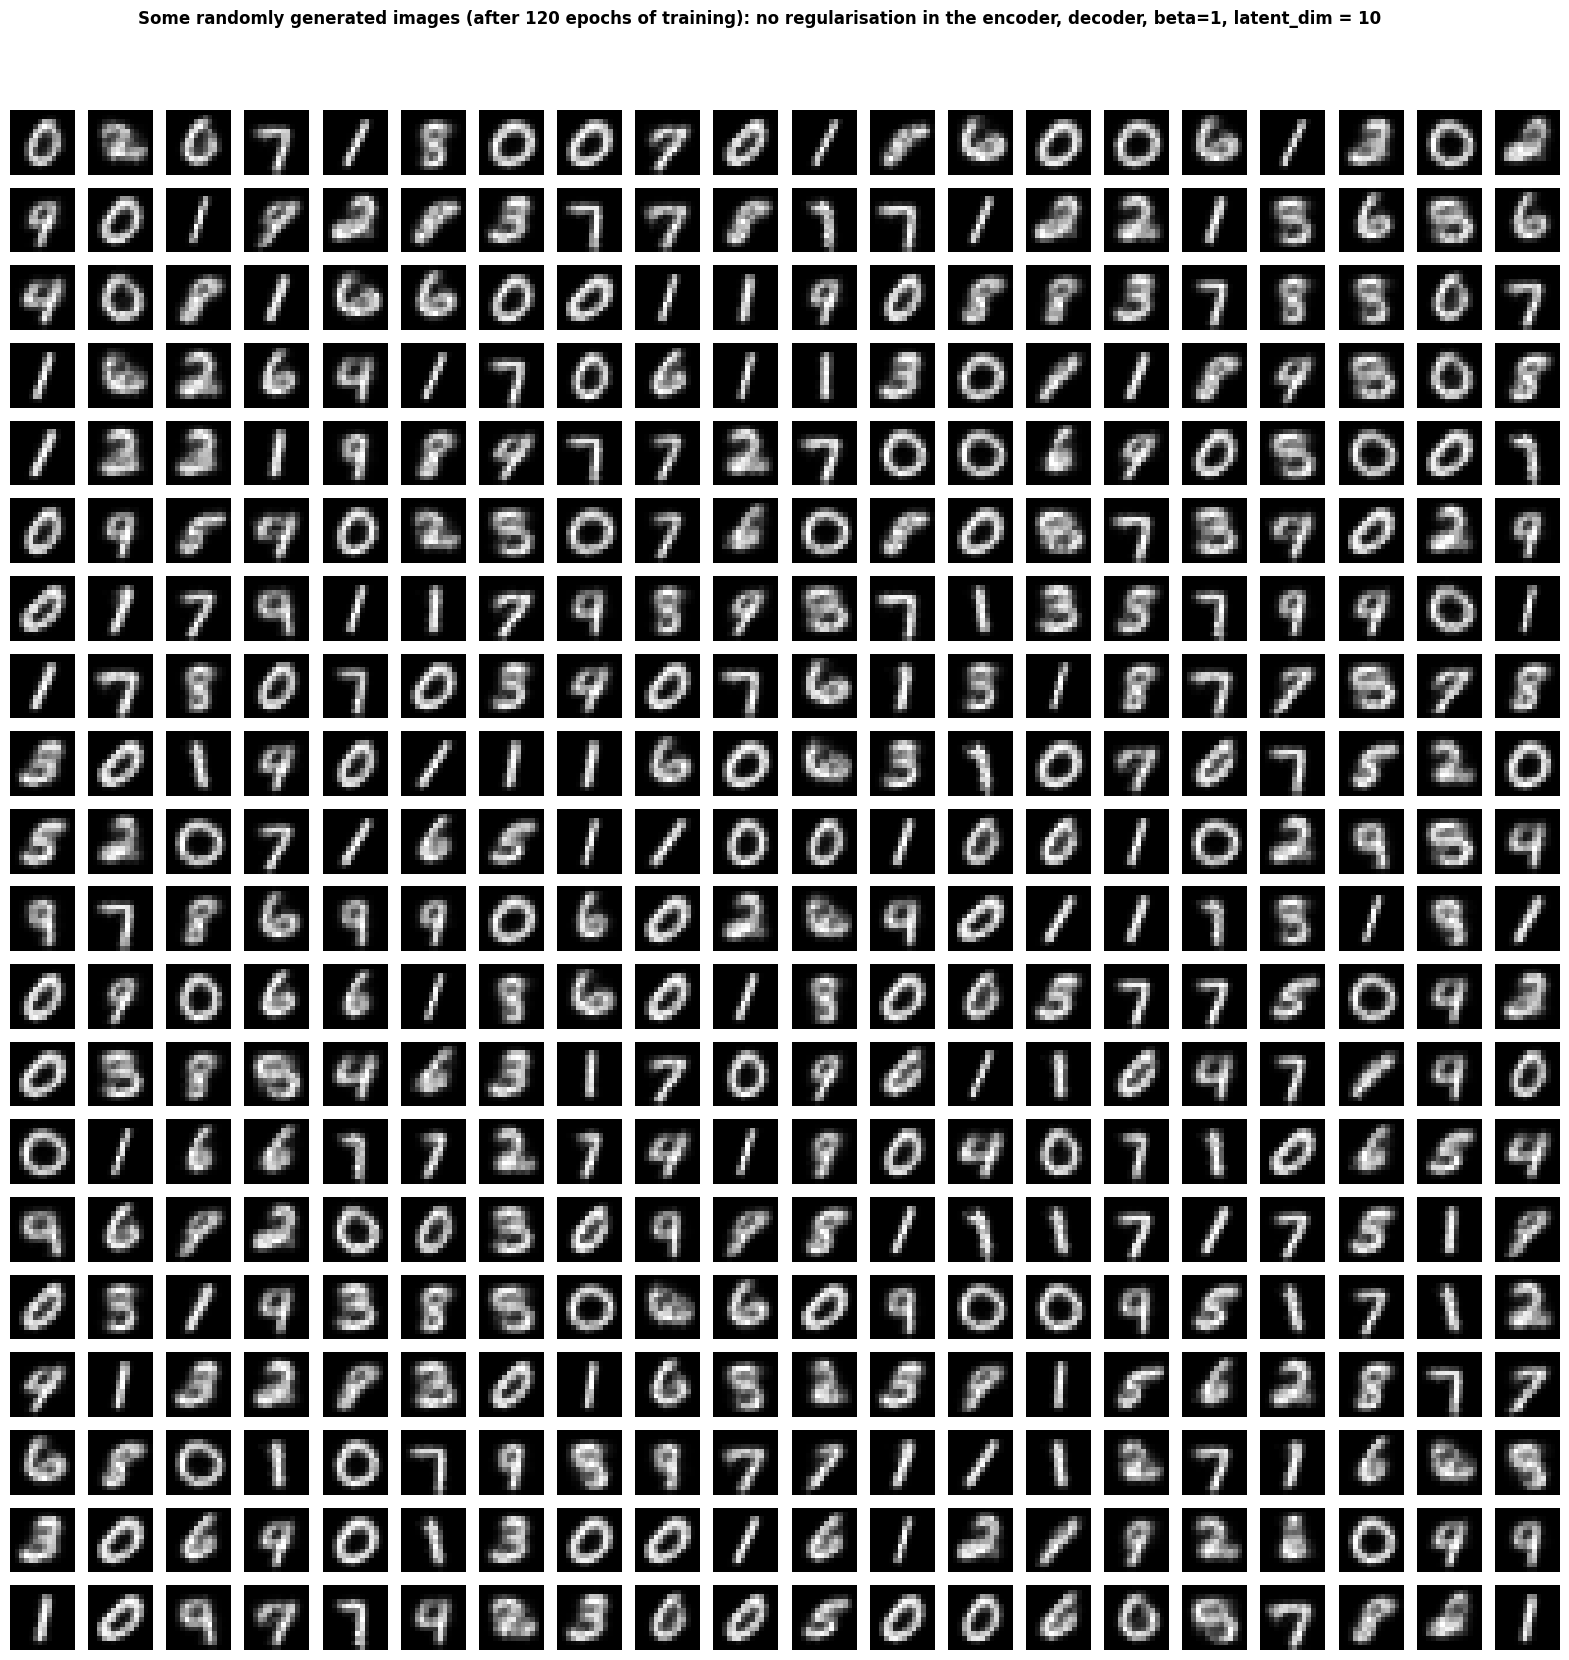

In [58]:
plot_generated(scale=2,edge=20,epochs=120)